# Progress Week 3/8

## I am Behind
Weeks ago (around the end of January), I tried to outline a timeline for milestones on this project:

| Week | Milestone |Description |
| ---- | --------- | ---------- 
| 1 | Match | Demonstrate (or not) equivalence to CMR across datasets.
| 2 | Distinguish (Theory) | Clarify latent theoretical distinctions between models, linking these with testable predictions and the literature. |
| 3 | Distinguish (Data) | Prove proposed distinctions are real (or not!) by relating models to relevant existing data sets.
| 4 | Update | Update model specification based on results, and re-analyze.
| 5+ | Relate | Connect ICMR to other instance-based models, e.g. ITS. | 
| Beyond | Convey | Develop paper, presentations, supplementary analyses. |

I thought by March I'd be focused on developing our paper/presentations/supplementary analyses, but over a week in, I'm still stuck on 1-4, which turn out to overlap way too much for meaningful segmentation into different weeks. These last few weeks haven't been totally unproductive; I've hit big milestones when it comes to tackling passageFR maturely and we've definitely substantially improved our understanding of how ICMR and CMR differ. But this project is definitely off timeline.

## New Plan
Considered seriously, it does seem that I'll need the rest of the month to flesh out a core group of analyses for inclusion in my April 21 presentation and in our paper. Since we now understand that comparing/contrasting/updating CMR/ICMR and reporting the outcomes of these results can't be cleanly separated into unique milestones, it's probably better to identify milestones in terms of how we'll carry out these comparisons.

First, we still need to establish that the models support fits to free recall data in the same way, at least when items are presented once. Second, there are principled reasons to suppose that the models differ with respect to the way they handle repetitions of the same item within and across contexts; we'll want to analyze those differences as well. Third, the models seem to differ greatly in how they encode semantic associations and/or non-orthogonal item representations. And finally, ICMR seems more supportive of integration with other modeling ideas rooted in instance-based frameworks, and that's worth demo-ing, too.

This week, we'll finish up, or at least reach a point of satisfaction with, our comparison between CMR and ICMR on the Murdoch dataset.

Next week, we'll finally focus in repetitions. We'll start with some toy examples to clarify our intuitions about how the models differ, and then we'll test these intuitions by testing fits to relevant datasets.

The following week, we'll try to characterize CMR's challenges encoding non-orthogonal item representations and leverage a combination of ITS and ICMR to overcome them.

No matter how far we actually get on these objectives, April needs to be devoted to pulling together a cohesive presentation for the cogsci seminar. I can add supplementary analyses only directly for that purpose, or if I have time after pulling a presentation together. 

I should probably do at least one practice presentation on April the 16th or 9th.

This leaves the following milestone:

| Date | Milestone |Description |
| ---- | --------- | ---------- 
| 3/12 | Free Recall | Characterize performance on regular free recall task
| 3/19 | Repetition | Characterize capacity to account for effect of item repetitions
| 3/26 | Semantics | Prove proposed distinctions are real (or not!) by relating models to relevant existing data sets.
| 4/9 or 4/16 | Practice | Compile and present practice presentation to lab
| 4/21 | Present | Cogsci seminar presentation
| 5/2 | Draft | Paper draft ready for Sean's review + committee meeting

## This Week: Free Recall and Debugging
Somewhere along my attempts to equate ICMR and CMR, my codebase got messy and my implementations of both models got worse: CMR and ICMR both run more slowly and fit worse to datasets I've considered so far. So I'm probably spending the bulk of this week retracing my steps, hopefully culminating by our meeting to a full comparison of model performance fitting to a full Murdoch72 dataset (at least the 20 item one).

We'll go for a spirit of minimalism. What would be necessary in a talk about ICMR for this section? One main example "traditional" dataset is probably sufficient so long as we stick to free recall in successive experiments, too.

Along with debugging to ensure model fits are accurate and snappy, we'll do a few extensions now so we don't have to reinstate context to perform them later:
- 30 items as well as 20 items to confirm that model comparison patterns generalize as item count changes
- Compare different versions of ICMR (location of exponentiation, altered similarity function??)
- Comparison of fits with some statistical test

Then with any free time we'll perform initial simulations to support analyses we'll be doing in follow-up weeks.

**Question for Sean:** How worthwhile is it to try for a fit across list lengths? **Yes.**

**Should probably look at different data sets**. Any from MortPolyn2016. The one with the most data.

## Debugging
I spent a lot of time trying to work out bugs in how CMR and ICMR were doing model fitting. At first, I'd thought they were just slower, but when I tried to fit on the entire 20-item dataset, I instead found that fitting failed - and rather than return any error message, my kernel died. At the same time, a lot of obscure warning messages popped up as I operated these models; some about numba and others while using scipy's fitting library. All bugs have been explained and addressed.

**In Jit-compiled mode, kernel crashed during fitting instead of returning any error.** This is found to be a behavior of numba; if it happens I should re-run code without jit compilation and will see useful error messages. In general, testing every bit of code with numba turned off is an important step for ensuring my code actually works.

**I/CMR was assigning 0 likelihood to some events for some parameter configurations.** This maybe requires consultation with Sean. I realized that this result is a logical consequence of making the probability of recalling other items conditional on not ending recall, an event whose probability scales up past 1 very quickly for many parameter configurations. When P(stop) = 1 according to the model, even if some baseline activation is assumed for each item, their outcome probabilities will be zero. Fortunately, this doesn't actually seem to disrupt the course of model fitting, so I've left the bug standing. **Ask Sean for Guidance**.

**NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 2d, A))** This turned out to be a quirk of numba; some arrays in a numba-compiled array aren't contiguous unless explicitly labeled as such. Labeling them correctly plus some related code changes sped up code considerably and eliminated these warnings. 

**Likelihood function wasn't appropriately coding error for failure to predict stopped recall.** I found that this error had two parts. First, I had assumed my trials matrix containing recall data had the same number of columns as the number of items to be recalled, and thus used column count (or just 0, the dummy variable in trials coding recall termination) for a variety of cues where I should have used item_count. Second, my code timed transitions to the next trial for computing data likelihoods improperly so that estimated probabilities of stopping weren't tracked. All these are fixed now.

This seems to summarize all the bugs I tackled over the past week, but I may be missing some minor ones, too, idk.

## How Will We Compare Fits?
I still don't really know. I understand that technically I can do a chisquared test using the log-likelihoods, but it seems ambiguous? Is there really no factor for sample size? Kind of odd. **Ask Sean for Guidance**.

In [ ]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

**Go for AIC**. Can compare using a weighted AIC; ratio suggests scale of difference in performance between two.

## Model Fits to Murdoch72, LL=20
We'll compare against CMR as well as against some interesting modifications of ICMR.

### ICMR with isolated sensitivity parameter
```
     fun: 1066.6198672539826
 message: 'Optimization terminated successfully.'
    nfev: 12411
     nit: 74
 success: True
       x: array([7.83057993e-01, 8.43579311e-03, 8.41344768e-01, 5.16132856e-03,
       9.28416235e-01, 1.90157671e-01, 1.00393775e+01, 3.25689988e+01,
       1.17197475e-02, 3.87954549e-01, 1.57952789e+00])
```
for one subject

```
     fun: 21305.459463112817
 message: 'Optimization terminated successfully.'
    nfev: 11256
     nit: 67
 success: True
       x: array([7.36326137e-01, 1.00379697e-01, 7.67841674e-01, 6.28420587e-03,
       6.64308038e-01, 1.13018109e-01, 4.42113403e+00, 5.71897928e+01,
       4.15564566e-02, 2.17469284e-01, 1.79295669e+00])
```
for all subjects

### ICMR: If I move the sensitivity exponential to affect encoding, too

```
     fun: 1066.928495687557
 message: 'Optimization terminated successfully.'
    nfev: 17196
     nit: 103
 success: True
       x: array([8.36353524e-01, 8.13803889e-03, 7.85335816e-01, 3.90997688e-03,
       7.44171678e-01, 3.51124039e-01, 5.32479200e+00, 3.91069355e+01,
       1.85132603e-02, 3.35514090e-01, 1.45915070e+00])
```
for one subject

```
     fun: 21189.361909423762
     jac: array([  370.85883191,   395.01792365,  -284.3506067 , -4803.43042003,
          54.62388772,   182.5606888 ,   -16.67685875,     0.        ,
       -5460.87867314, -2637.80421076,   -19.46173154])
 message: 'Optimization terminated successfully.'
    nfev: 11199
     nit: 66
 success: True
       x: array([7.46510490e-01, 6.39097142e-02, 8.24181640e-01, 4.02289265e-03,
       5.34680153e-01, 2.72774711e-01, 4.47377578e+00, 4.97277656e+01,
       3.86851140e-02, 2.30541281e-01, 1.53490018e+00])
```
for all subjects

The fit is a little better, even though the deviation from CMR is greater. (In CMR taking any exponent by the sensitivity parameter only happens at retrieval).

I like the idea of sticking with the exponent because the model then works a bit more like MINERVA 2. It does slow down simulation though, since `activation` gets called a lot more often then `outcome_probs` - though I suppose, all that extra computation only happens at encoding, which happens once per call to data_likelihood.

### CMR
f was 1070.57 for a single subject, and 21224 for all subjects.

## Murdoch72, LL=30

### CMR
```
     fun: 29342.629671667088
 message: 'Optimization terminated successfully.'
    nfev: 8946
     nit: 53
 success: True
       x: array([0.70069255, 0.12762617, 0.80337953, 0.41714768, 0.23858659,
       0.2371702 , 3.06854857, 2.80868485, 0.01451982, 0.29022003,
       6.82760494])
```

The following code won't work, but the images are good.

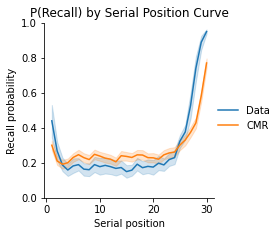

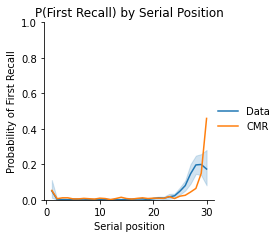

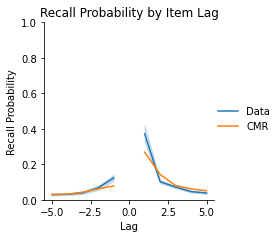

In [ ]:
visualize_fit(CMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events, 'subject > -1', experiment_count=1000, savefig=True)

### Instance_CMR

```
     fun: 29486.748135343634
 message: 'Optimization terminated successfully.'
    nfev: 11091
     nit: 66
 success: True
       x: array([7.51778328e-01, 1.81171963e-01, 8.40312861e-01, 1.62188236e-02,
       8.49216562e-01, 5.03723251e-01, 2.62559244e+00, 8.22896982e+01,
       2.91993847e-02, 2.05712497e-01, 2.66155244e+00])
```

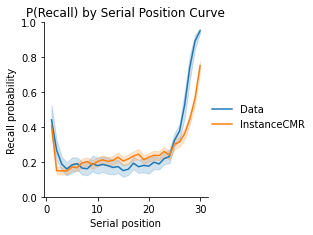

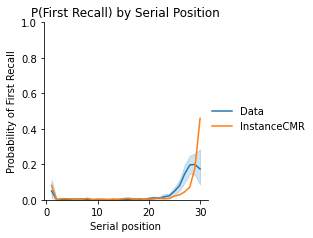

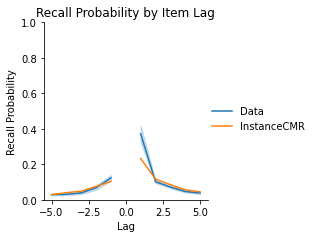

In [ ]:
visualize_fit(InstanceCMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events, 'subject > -1', experiment_count=1000, savefig=True)

### InstanceCMR With Isolated Sensitivity Exponent
```
     fun: 29284.595899995107
 message: 'Optimization terminated successfully.'
    nfev: 11751
     nit: 70
 success: True
       x: array([7.84768896e-01, 1.48203114e-02, 8.14602350e-01, 5.55676807e-03,
       4.67412304e-01, 1.75643588e-01, 4.14677903e+00, 5.42977817e+01,
       2.72873865e-02, 2.32685292e-01, 1.91895370e+00])
```

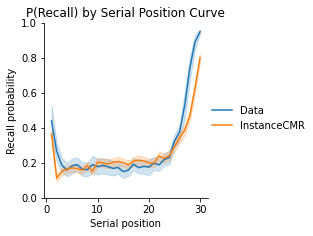

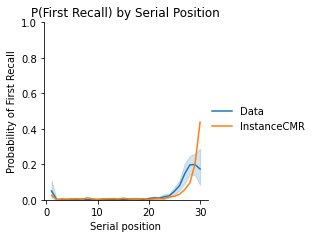

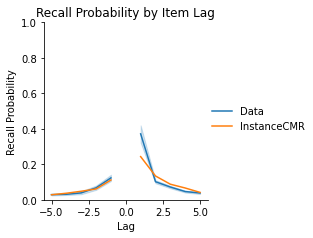

In [ ]:
visualize_fit(InstanceCMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events, 'subject > -1', experiment_count=1000, savefig=True)

Here, isolating the sensitivity exponential to outcome probabilities results in the best fitting model, leaving ambiguous which version of ICMR is the best to focus on going forward.

## What's Next: Investigating Nonlinear Activation of Stored Instances

The story of why CMR needs item features to be orthogonal and why CMR and ICMR might predict different handling of item repetitions seems to be closely related to why ITS handles homonyms better than DSMs.

### Nonlinear Activation of Stored Instances Within an Integration-at-Encoding Model is Possible if Instances Are Orthogonal Only
As Jamieson et al (2018) reiterate a lot, an integration-at-retrieval model can produce nonlinear activation of stored instances based on cue similarity, while integration-at-encoding models (like CMR) cannot. CMR seems to sidestep this problem, though, with two commitments:

1. **It makes feature unit activations corresponding to each item orthogonal**. The result is that each index of the activation vector generated during retrieval corresponds directly to support for a particular item/experience/memory trace. 
2. **When transforming activations into probabilities, it applies a sensitivity parameter that nonlinearly scales the contrast between well-supported and poorly supported items.** The result is that CMR effectively also produces nonlinear activation of stored instances. 

While item feature representations are orthogonal, this sensitivity scaling step has the same consequence whether you perform it before or after doing your sum of trace vectors. So you can do abstraction-at-encoding while still enjoying the dividends of activating traces nonlinearly based on cue similarity.

What happens as you break down the one-to-one correspondence between each feature unit and some specific item? This apparent correspondence between outcomes of nonlinear scaling whether performed before or after integration also breaks down. Taking the cube of the first entry of your activation vector in CMR is no longer equivalent to scaling the activation of a subset of traces based on cue similarity. Even if you select some other function for relating entries in your activation vector to support for retrieval of nonorthogonal item representations, information from the memory system is no longer enhanced or suppressed based on the similarity of associated experiences to the probe but rather in a more splintered way where feature unit are modulated in isolation.

By performing nonlinear activation over traces instead of over the collapsed activation vector, ICMR can have non-orthogonal item representations _without_ any breakdown in learning.

### Nonlinear Modulation of Trace Activations and of Echo Activations Have Different Consequences

Both CMR and ICMR can be interpreted as producing echoes upon cue by a probe. The timing of integration of experience information to produce these echoes (at encoding or at retrieving) is their main distinction. But ICMR can apply its sensitivity scaling parameter to traces activations (as normally occurs in MINERVA 2-based models) while CMR only has the option to apply them to the fully integrated echo representations. What's the difference?

Well, if echoes in either model are summations of activations supported by each experience encoded, the difference is big. If your sensitivity parameter is set to 3 and each relevant experience is activated by a value of 2, for example, then scaling trace activations before integration is like computing $2^3 + 2^3 + 2^3 + ...$ while scaling only the integrated activation is like computing $(2 + 2 + 2 + ...)^3$. When there are 3 experiences, this is the difference between 24 and 216. 

This difference can emerge even if we stick to orthogonal item representations; it should be observable even when such representations are repeatedly encoded.

How will we show it? Encode single presentation of each item as normal. Pick a static contextual cue that offers balanced support for each item (the balance isn't very important). Track change in outcome_probability of a selected item as it is repeatedly encoded into the model. We predict the result to be linear for ICMR but exponential for CMR.

Context complicates this a bit, but we can use a static contextual representation to build up intuition for this, and then confirm that the principle still holds when context varies normally. Because of the additive dynamics of Hebbian learning, we expect there